In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import numpy as np 
import pandas as pd  
import torch
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import torch.nn.functional as F 

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import resnet50

In [25]:
class CNFG:
    epochs =20                             
    lr = 0.001                             
    batch_size = 256           
    img_size = 224
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cuda


In [5]:
data_transform = T.Compose([
                             T.Resize(size=(CNFG.img_size,CNFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
                            
])

In [6]:
data_dir = '/content/gdrive/MyDrive/Space/solar_data/Train'

data = datasets.ImageFolder(data_dir,       
                    transform=data_transform)
total_count = len(data) 
total_count

2214

In [7]:
train_count = int(0.7 * total_count) 
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))  
print("Train data: {} images".format(len(train_data))) 
print("Validation data: {} images".format(len(val_data))) 
print("Test data: {} images".format(len(test_data)))

Train data: 1549 images
Validation data: 442 images
Test data: 223 images


In [8]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [9]:
train_data.dataset.classes

['Annular_solar_eclipse', 'Partial_solar_eclipse', 'Total_solar_eclipse']

In [10]:
train_data

In [11]:
trainloader = DataLoader(train_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))  
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:49
No. of Total examples:1549
No. of batches in validationloader:14
No. of Total examples:442
No. of batches in testloader:7
No. of Total examples:223


In [12]:
trainloader

In [13]:
from torch import nn
import torch.nn.functional as F
# import timm # PyTorch Image Models

model = resnet50(pretrained=True) #load pretrained model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
#Updating the pretrained model:
for param in model.parameters():
    param.requires_grad=True

In [16]:
model.fc = nn.Linear(in_features=2048,out_features = 3, bias=True)

In [17]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
import torch
torch.cuda.empty_cache()

In [19]:

from torchsummary import  summary
model.to(device)# move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [27]:
class ModelTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular 

    
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0

        for e in range(21):
          for images,labels in tqdm(trainloader): 
              
              # move the data to GPU
              images = images.to(device)
              labels = labels.to(device)
              
              outputs = model(images)
              loss = self.criterion(outputs,labels)
              
              self.optimizer.zero_grad()
              loss.backward()
              self.optimizer.step()
              
              train_loss += loss.item()
              train_acc += accuracy(outputs,labels)
            
          return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        for e in range(21):
          for images,labels in tqdm(validloader):
              
              # move the data to GPU
              images = images.to(device) 
              labels = labels.to(device)
              
              outputs = model(images)
              loss = self.criterion(outputs,labels)
              
              valid_loss += loss.item()
              valid_acc += accuracy(outputs,labels)
            
          return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() 
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) 
            
            model.eval()  
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) 
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'solar_resnet_50.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CNFG.lr)

trainer = ModelTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = 20)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.2049905862659216
Epoch : 1 Train Loss : 0.202963 Train Acc : 0.936568
Epoch : 1 Valid Loss : 0.204991 Valid Acc : 0.930804


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Valid_loss decreased 0.2049905862659216 --> 0.05672596760892442
Epoch : 2 Train Loss : 0.094936 Train Acc : 0.973214
Epoch : 2 Valid Loss : 0.056726 Valid Acc : 0.979911


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.047383 Train Acc : 0.982486
Epoch : 3 Valid Loss : 0.060352 Valid Acc : 0.976648


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.129945 Train Acc : 0.958546
Epoch : 4 Valid Loss : 0.292280 Valid Acc : 0.930288


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Valid_loss decreased 0.05672596760892442 --> 0.019829234773559228
Epoch : 5 Train Loss : 0.130591 Train Acc : 0.960165
Epoch : 5 Valid Loss : 0.019829 Valid Acc : 0.997768


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.030436 Train Acc : 0.989796
Epoch : 6 Valid Loss : 0.033477 Valid Acc : 0.988324


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.052618 Train Acc : 0.981848
Epoch : 7 Valid Loss : 0.176786 Valid Acc : 0.963255


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.028832 Train Acc : 0.992347
Epoch : 8 Valid Loss : 0.046093 Valid Acc : 0.984375


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Valid_loss decreased 0.019829234773559228 --> 0.004784294441508662
Epoch : 9 Train Loss : 0.025352 Train Acc : 0.995536
Epoch : 9 Valid Loss : 0.004784 Valid Acc : 1.000000


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.023404 Train Acc : 0.990139
Epoch : 10 Valid Loss : 0.035134 Valid Acc : 0.988839


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.099921 Train Acc : 0.973852
Epoch : 11 Valid Loss : 0.311190 Valid Acc : 0.906422


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Valid_loss decreased 0.004784294441508662 --> 0.004342162769587178
Epoch : 12 Train Loss : 0.025353 Train Acc : 0.993328
Epoch : 12 Valid Loss : 0.004342 Valid Acc : 1.000000


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Valid_loss decreased 0.004342162769587178 --> 0.003470986129416685
Epoch : 13 Train Loss : 0.023379 Train Acc : 0.992985
Epoch : 13 Valid Loss : 0.003471 Valid Acc : 1.000000


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.048959 Train Acc : 0.987245
Epoch : 14 Valid Loss : 0.111803 Valid Acc : 0.968235


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.043981 Train Acc : 0.989158
Epoch : 15 Valid Loss : 0.003484 Valid Acc : 1.000000


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.013046 Train Acc : 0.997449
Epoch : 16 Valid Loss : 0.003773 Valid Acc : 0.997768


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Valid_loss decreased 0.003470986129416685 --> 0.0017628402181019606
Epoch : 17 Train Loss : 0.010612 Train Acc : 0.997449
Epoch : 17 Valid Loss : 0.001763 Valid Acc : 1.000000


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Valid_loss decreased 0.0017628402181019606 --> 0.00047148427568442585
Epoch : 18 Train Loss : 0.008529 Train Acc : 0.998724
Epoch : 18 Valid Loss : 0.000471 Valid Acc : 1.000000


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.099434 Train Acc : 0.971939
Epoch : 19 Valid Loss : 0.110142 Valid Acc : 0.964286


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.021867 Train Acc : 0.992985
Epoch : 20 Valid Loss : 0.084273 Valid Acc : 0.982143


In [29]:
torch.save(model.state_dict(),'solar_resnet_50.pt')

In [30]:
# test predictions
# load torch model 
# model.load_state_dict(torch.load('ocean_19_15.pt'))
model.load_state_dict(torch.load('solar_resnet_50.pt'))
model.eval()
test_loss = 0.0
test_acc = 0.0
for images,labels in tqdm(testloader):
        
        # move the data to GPU
        images = images.to(device) 
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        test_loss += loss.item()
        test_acc += accuracy(outputs,labels)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(test_loss / len(testloader), test_acc / len(testloader)))

  0%|          | 0/7 [00:00<?, ?it/s]

Test Loss : 0.037262 Test Acc : 0.981999


## Make predictions

In [47]:
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F 
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import alexnet
from torch import nn


data_transform = T.Compose([
                             T.Resize(size=(224,224)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                            #  T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

]) 

class_map = [ 
    'Annular_solar_eclipse', 
    'Partial_solar_eclipse', 
    'Total_solar_eclipse'
]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# def predict_image(image_path,model):
#     image = Image.open(image_path)
#     image = data_transform(image)
#     image = image.unsqueeze(0)
#     image = image.to(device)
#     model.eval()
#     output = model(image)
#     output = F.softmax(output,dim = 1)
#     top_p,top_class = output.topk(1,dim = 1)
#     return top_class

# def predict_image_class(image_path,model):
#     image = Image.open(image_path)
#     image = data_transform(image)
#     image = image.unsqueeze(0)
#     image = image.to(device)
#     model.eval()
#     output = model(image)
#     output = F.softmax(output,dim = 1)
#     top_p,top_class = output.topk(1,dim = 1)
#     return top_class.item()

def predict_image_class_name(image_path,model): 
    
    # show image 
    imshow(data_transform(Image.open(image_path)))

    image = Image.open(image_path)
    image = data_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device) 
    output = model(image)
    output = F.softmax(output,dim = 1)
    print("soft" , output)
    top_p,top_class = output.topk(1,dim = 1) 
    print( top_p , top_class)
    # return "Predicted :", train_data.dataset.classes[top_class.item()]
    return "Predicted :", class_map[top_class.item()]

# device 
device = torch.device("cpu" if torch.cuda.is_available() else "cpu") 

# make realtime predictions 
model = resnet50(pretrained=True) #load pretrained model 
model.fc = nn.Linear(in_features=2048,out_features = 3, bias=True) 
model.load_state_dict(torch.load('solar_resnet_50.pt')) # load the model
model.to(device) 

def predict_img(image): 

    INPUT_DIM = 224 
    preprocess = T.Compose([
            T.Resize(INPUT_DIM ),
            T.CenterCrop(224),
            T.ToTensor(),
            # T.Normalize(
            # mean=[0.485, 0.456, 0.406],
            # std=[0.229, 0.224, 0.225])
         ])

    imshow(preprocess(Image.open(image)))

    im = Image.open(image)
    im_preprocessed = preprocess(im) 
    batch_img_tensor = torch.unsqueeze(im_preprocessed, 0)
    output = model(batch_img_tensor) 
    confidence = F.softmax(output, dim=1)[0] * 100 
    _, indices = torch.sort(output, descending=True) 
    return [(class_map[idx], confidence[idx].item()) for idx in indices[0][:1]]


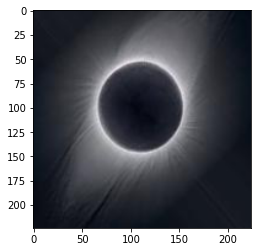

[('Total_solar_eclipse', 90.61613464355469)]

In [48]:
predict_img("/content/gdrive/MyDrive/Space/solar_data/Test/Total_Solar_Eclipse/Augmented_0__0_7875.jpeg")

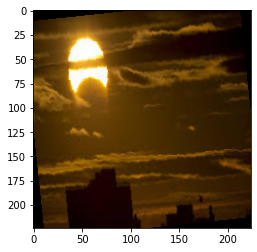

soft tensor([[4.3832e-04, 5.0444e-01, 4.9512e-01]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5044]], grad_fn=<TopkBackward0>) tensor([[1]])


('Predicted :', 'Partial_solar_eclipse')

In [89]:
predict_image_class_name('/content/gdrive/MyDrive/Space/solar_data/Train/Partial_solar_eclipse/21.jpg',model) 